# Testes da Funcao BilinearRLS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [3]:
# --- 1. CONFIGURAÇÃO DO SISTEMA NÃO LINEAR ---
np.random.seed(42)
n_samples = 3000

# Sinal de entrada (Ruído Branco Real)
x = np.random.randn(n_samples)

# Modelo de Planta Bilinear (Sinal Desejado)
# d[k] = 0.5*x[k] - 0.3*d[k-1] + 0.2*x[k]*d[k-1] + 0.1*x[k-1]*d[k-1] + ruído
d = np.zeros(n_samples)
w_true = np.array([0.5, -0.3, 0.2, 0.1])

for k in range(1, n_samples):
    d[k] = (w_true[0] * x[k] + 
            w_true[1] * d[k-1] + 
            w_true[2] * x[k] * d[k-1] + 
            w_true[3] * x[k-1] * d[k-1])
    
# Adiciona um pouco de ruído de medição
d += 0.05 * np.random.randn(n_samples)

# --- 2. EXECUÇÃO DO FILTRO BILINEAR RLS ---
# forgetting_factor (lambda): controla a memória do filtro
# delta: inicialização da matriz P (P = I/delta)
filt = pdf.BilinearRLS(
    forgetting_factor=0.99,
    delta=0.1
)

result = filt.optimize(x, d, verbose=True)

[BilinearRLS] Completed in 21.916 ms


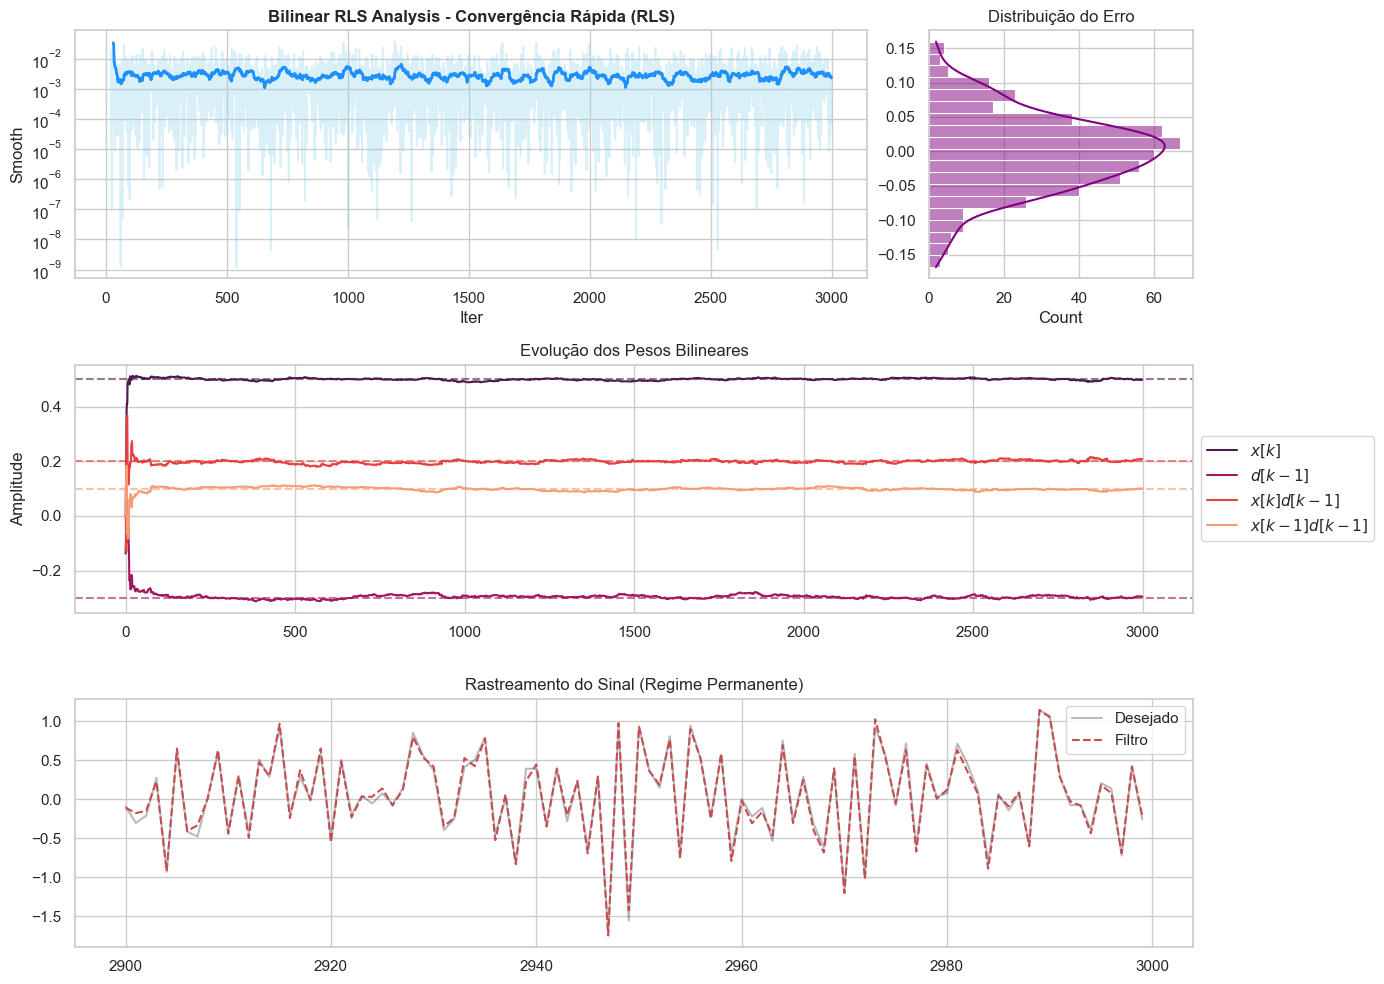

In [4]:
# --- 3. VISUALIZAÇÃO COM SEABORN (FANCY PLOT) ---

def plot_bilinear_results(result, w_true, title):
    sns.set_theme(style="whitegrid")
    mse = result.mse()
    coeffs = result.coefficients[1:]
    t = np.arange(len(mse))
    offset = 20

    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, width_ratios=[3, 1], height_ratios=[1, 1, 1])

    # A. Curva de Aprendizado (MSE)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.lineplot(x=t[offset:], y=mse[offset:], ax=ax1, color="skyblue", alpha=0.3)
    mse_df = pd.DataFrame({'Iter': t, 'MSE': mse})
    mse_df['Smooth'] = mse_df['MSE'].rolling(window=30).mean()
    sns.lineplot(x='Iter', y='Smooth', data=mse_df.iloc[offset:], ax=ax1, color="dodgerblue", lw=2)
    ax1.set_yscale('log')
    ax1.set_title(f"{title} - Convergência Rápida (RLS)", fontweight='bold')

    # B. Erro Residual
    ax2 = fig.add_subplot(gs[0, 1])
    sns.histplot(y=result.errors[-500:], kde=True, ax=ax2, color="purple")
    ax2.set_title("Distribuição do Erro")

    # C. Trajetória dos Coeficientes (Comparação Direta)
    ax3 = fig.add_subplot(gs[1, :])
    labels = ['$x[k]$', '$d[k-1]$', '$x[k]d[k-1]$', '$x[k-1]d[k-1]$']
    palette = sns.color_palette("rocket", 4)
    
    for i in range(4):
        sns.lineplot(x=t, y=coeffs[:, i], ax=ax3, color=palette[i], label=labels[i])
        ax3.axhline(y=w_true[i], color=palette[i], linestyle='--', alpha=0.6)
    
    ax3.set_title("Evolução dos Pesos Bilineares")
    ax3.set_ylabel("Amplitude")
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # D. Comparação de Saída (Últimas 100 amostras)
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(t[-100:], d[-100:], 'k-', alpha=0.3, label='Desejado')
    ax4.plot(t[-100:], result.outputs[-100:], 'r--', label='Filtro')
    ax4.set_title("Rastreamento do Sinal (Regime Permanente)")
    ax4.legend()

    plt.tight_layout()
    plt.show()

plot_bilinear_results(result, w_true, "Bilinear RLS Analysis")